This is a Jupyter notebook designed to help me visualize, and work with, raster data collected by NASA's Shuttle Radar Topography Mission (SRTM). This data is freely available to the public, and can be found at:
https://www2.jpl.nasa.gov/srtm/

The extent that is being mapped are the SMGL districts for Western Uganda - which I've used in previous cost-friction surface analyses.

The data distribution website for the entire SRTM project can be found at: https://www.usgs.gov/centers/eros.

I based this off of the UC Boulder Earth Data Science tutorial for raster data analysis. 
https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/open-lidar-raster-python/

However, in this iteration, I put my own spin on the data analysis.

Written by Michelle Schmitz, 12/03/2019

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
import seaborn as sns
sns.set(font_scale=1.5, style="white")

In [2]:
##definition of objects at the top of the file for purposes of keeping it clean

#path = "[REDACTED]/DEM" #removed for personal concerns

os.chdir(os.path.join(path)) #adding path to current path
#path

#defining the raster object below that will be used in subsequent analyses - this can be changed later on

rast_ug = 'STRM_CLIPPED_CombinedDEMs.tif'

In [3]:
lidar_dem = rio.open(rast_ug)

lidar_dem.bounds

BoundingBox(left=29.140416666656577, bottom=-1.6370827521981357, right=32.33958333332324, top=1.4620839144685305)

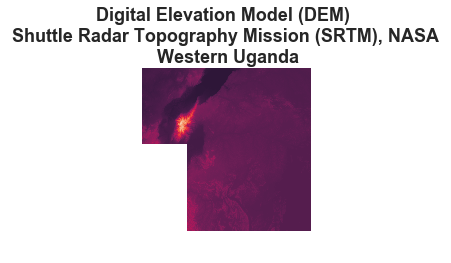

In [4]:
# Plot the dem using raster.io
fig, ax = plt.subplots(figsize = (8,3))
show(lidar_dem, 
     title="Digital Elevation Model (DEM) \n Shuttle Radar Topography Mission (SRTM), NASA \n Western Uganda", 
     ax=ax)
ax.set_axis_off()

In [5]:
# The below code is supposed to:
#     open the raster
#     create a spatial_extent object that contains the boundary information needed to plot your raster in space using rio.plot.plotting_extent
#     Read in the raster data itself into a numpy array using .read()

with rio.open(rast_ug) as src:
    # Convert / read the data into a numpy array:
    lidar_dem_im = src.read()
    # Create a spatial extent object using rio.plot.plotting
    spatial_extent = rio.plot.plotting_extent(src)
    # Get bounds of object
    bounds = src.bounds

In [6]:
lidar_dem_im #we can now see that this is now read as an array

array([[[  877,   875,   881, ...,  1066,  1063,  1060],
        [  881,   877,   881, ...,  1066,  1062,  1060],
        [  886,   880,   884, ...,  1063,  1062,  1060],
        ...,
        [32767, 32767, 32767, ...,  1134,  1134,  1134],
        [32767, 32767, 32767, ...,  1134,  1134,  1134],
        [32767, 32767, 32767, ...,  1134,  1134,  1134]]], dtype=uint16)

In [7]:
spatial_extent #see spatial extent of the object - should have the same params as lidar_dem.bounds

(29.140416666656577,
 32.33958333332324,
 -1.6370827521981357,
 1.4620839144685305)

In [8]:
bounds #again, same as lidar_dem.bounds

BoundingBox(left=29.140416666656577, bottom=-1.6370827521981357, right=32.33958333332324, top=1.4620839144685305)

In [9]:
# Replotting the bounding box into the CORRECT format needed by MatPlotLib (left - bottom, right, top)

print("spatial extent:", spatial_extent)
# This is the format that rasterio provides with the bounds attribute
print("rasterio bounds:", bounds)

spatial extent: (29.140416666656577, 32.33958333332324, -1.6370827521981357, 1.4620839144685305)
rasterio bounds: BoundingBox(left=29.140416666656577, bottom=-1.6370827521981357, right=32.33958333332324, top=1.4620839144685305)


In [10]:
#Read Files with Rasterio into Numpy

with rio.open(rast_ug) as src:
    # convert / read the data into a numpy array: masked= True turns `nodata` values to nan
    lidar_dem_im = src.read(1, masked=True)
    # create a spatial extent object using rio.plot.plotting
    spatial_extent = rio.plot.plotting_extent(src)

print("object shape:", lidar_dem_im.shape)
print("object type:", type(lidar_dem_im))

object shape: (3719, 3839)
object type: <class 'numpy.ma.core.MaskedArray'>


In [11]:
with rio.open(rast_ug) as src:
    # Convert / read the data into a numpy array:
    lidar_dem_im2 = src.read(1)

with rio.open(rast_ug) as src:
    # Convert / read the data into a numpy array:
    lidar_dem_im3 = src.read()

print("Array Shape Using read(1):", lidar_dem_im2.shape)
# Notice that without the (1), the numpy array has a third dimension
print("Array Shape Using read():", lidar_dem_im3.shape)

Array Shape Using read(1): (3719, 3839)
Array Shape Using read(): (1, 3719, 3839)


In [12]:
## RASTER METADATA before getting started with plotting/reading this dataset

# View crs of raster imported with rasterio
with rio.open(rast_ug) as src:
    print(src.crs) 
#should line up to World Geodetic System (WGS) 1984 (EPSG: 4326), since I did not reproject this to another project system

EPSG:4326


In [13]:
# converting the ESPG string over to a proj4 string:
proj4 = et.epsg['4326']
print(proj4) #confirms that this is a WGS84 DEM (straight from STRM, prior to reprojection)

+proj=longlat +datum=WGS84 +no_defs


In [14]:
#raster resolution:
src.res 

#should show(0.0008333333333333333, 0.0008333333333333332), which reflects the number of DEGREES shown in each raster cell

(0.0008333333333333333, 0.0008333333333333332)

Plotting the Rasters in Different Ways

First, plotting the normal raster!

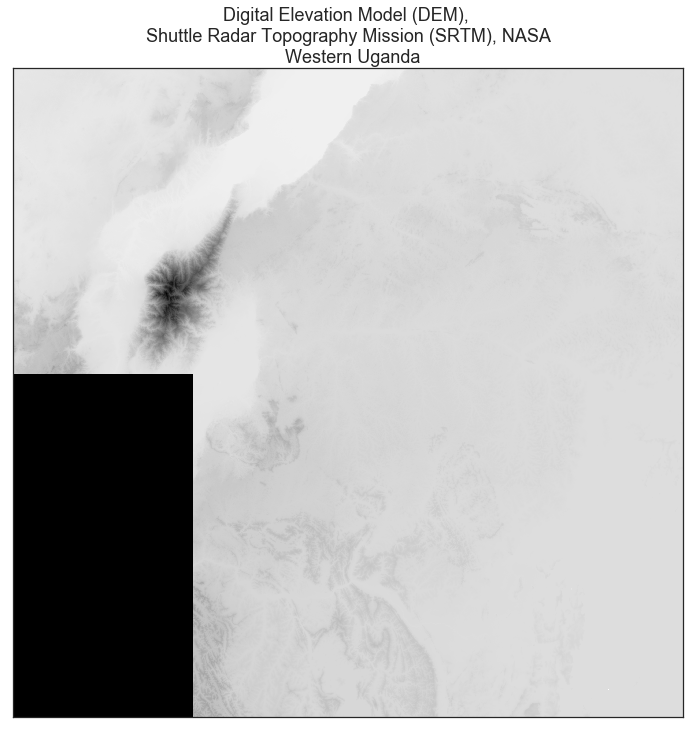

In [15]:
ep.plot_bands(lidar_dem_im,
              cmap='Greys',
              extent=spatial_extent,
              title="Digital Elevation Model (DEM), \n Shuttle Radar Topography Mission (SRTM), NASA \n  Western Uganda",
              cbar=False)

plt.show()

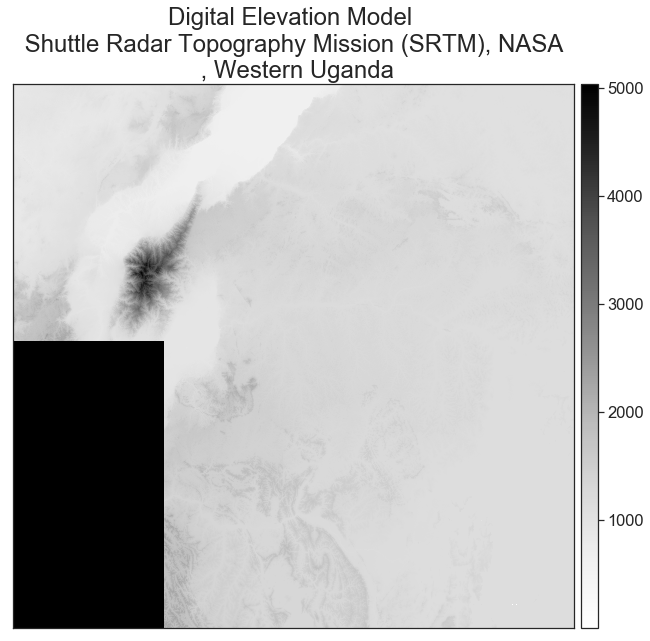

In [16]:
#similar plot, using both matplotlib and earthpy, to create an extra color bar and adding extra titles

fig, ax = plt.subplots(figsize=(12, 10))
ep.plot_bands(lidar_dem_im,
              cmap='Greys',
              extent=spatial_extent,
              scale=False,
              ax=ax)
ax.set_title("Digital Elevation Model \n Shuttle Radar Topography Mission (SRTM), NASA \n , Western Uganda", fontsize=24)
plt.show()

In [17]:
lidar_dem_im #values in array

masked_array(
  data=[[877, 875, 881, ..., 1066, 1063, 1060],
        [881, 877, 881, ..., 1066, 1062, 1060],
        [886, 880, 884, ..., 1063, 1062, 1060],
        ...,
        [5034, 5034, 5034, ..., 1134, 1134, 1134],
        [5034, 5034, 5034, ..., 1134, 1134, 1134],
        [5034, 5034, 5034, ..., 1134, 1134, 1134]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=32767,
  dtype=uint16)

In the original GeoTIFF, I was having trouble visualizing (in a 2D method) the elevation for the raster histogram.

All I 'knew' about this data was the following:
    * The Rwenzori mountains are the tallest mountain range in Africa
    * The main town in the region, Fort Portal, Uganda, is *roughly* the same height as Denver, CO, USA.

As a result, I thought this would be a particularly useful exercise to see just HOW MUCH elevation differences there would be!

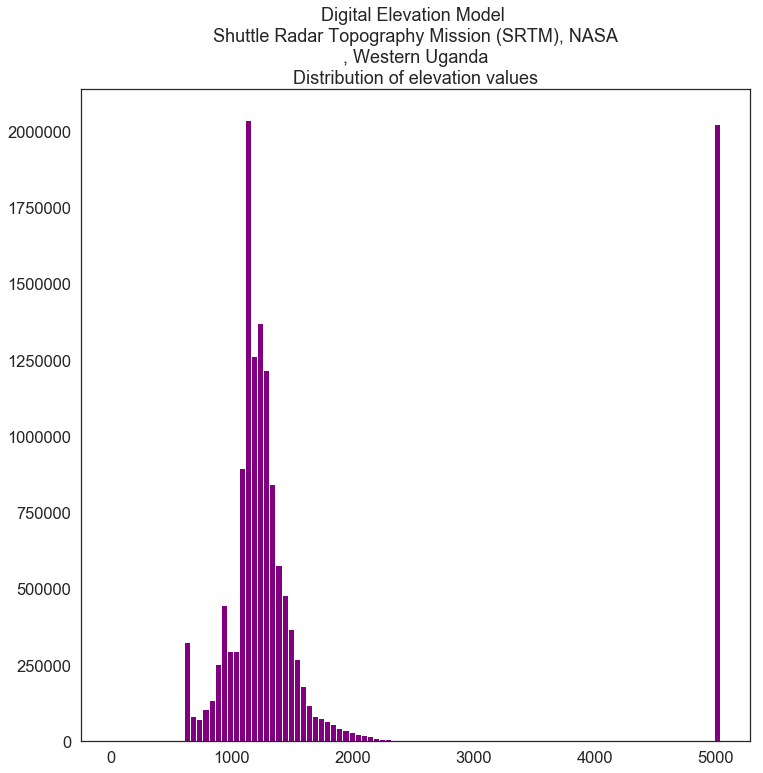

In [18]:
ep.hist(lidar_dem_im[~lidar_dem_im.mask].ravel(),
        bins=100,
        title="Digital Elevation Model \n Shuttle Radar Topography Mission (SRTM), NASA \n , Western Uganda \nDistribution of elevation values")

plt.show()

In [19]:
# The above isn't very useful - we see the "5000 [m]" entry, but it's an outlier. I'm curious to see if there's a distribution of heights listed.

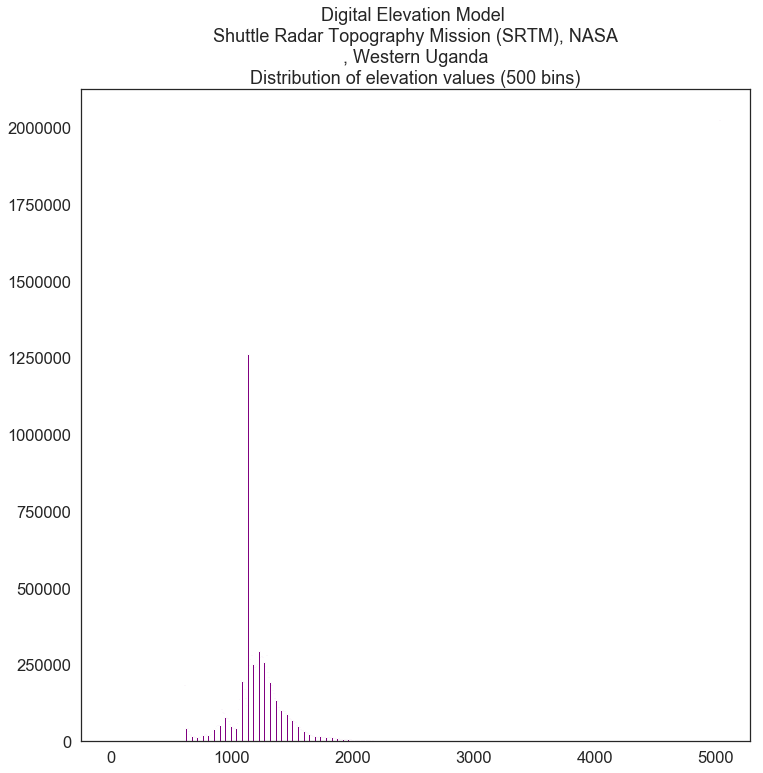

In [20]:
ep.hist(lidar_dem_im[~lidar_dem_im.mask].ravel(),
        bins=500,
        title="Digital Elevation Model \n Shuttle Radar Topography Mission (SRTM), NASA \n , Western Uganda \nDistribution of elevation values (500 bins)")

plt.show()

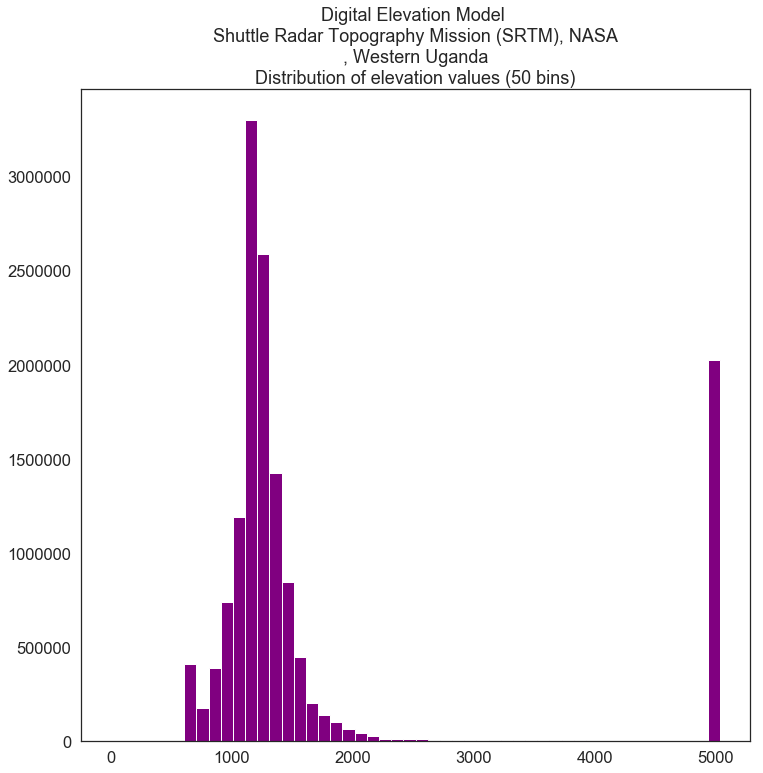

In [21]:
#downgrading the number of bins shown
ep.hist(lidar_dem_im[~lidar_dem_im.mask].ravel(),
        bins=50,
        title="Digital Elevation Model \n Shuttle Radar Topography Mission (SRTM), NASA \n , Western Uganda \nDistribution of elevation values (50 bins)")

plt.show()

In [22]:
## Defining a smaller spatial extent - specific to the Rwenzori mountains (the high peak shown), 
# because I want to see the full extent of the outlier

# The original lidar_dem.bounds command mentioned:
#BoundingBox(left=29.140416666656577, bottom=-1.6370827521981357, right=32.33958333332324, top=1.4620839144685305)

# the format of the zoomed extent is: minx, miny, maxx, maxy, ccw=True
# I determined the spatial extent using extract.bbbike.org
zoomed_extent = [29.65, 0.03, 30.3, 0.934]

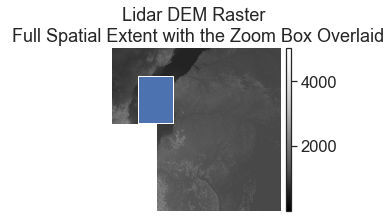

In [23]:
# Now, I'm adding a 'bounding box' that fits the same zoomed extent, on the original raster graphic, so it looks like we're forcing the bounding box on top of the raster.

zoom_ext_gdf = gpd.GeoDataFrame()
#zoom_ext_gdf_small = zoom_ext_gdf.loc[0, 'geometry'] = box(*zoomed_extent)
zoom_ext_gdf.loc[0, 'geometry'] = box(*zoomed_extent)

# Plot the original data with the boundary box
fig, ax = plt.subplots(figsize=(8, 3))
ep.plot_bands(lidar_dem_im,
              extent=spatial_extent,
              title="Lidar DEM Raster \n Full Spatial Extent with the Zoom Box Overlaid",
              ax=ax,
              scale=False)
zoom_ext_gdf.plot(ax=ax)

ax.set_axis_off()

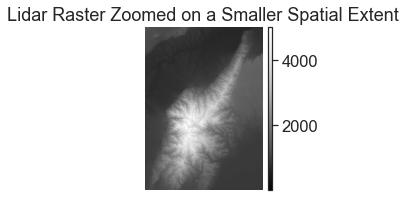

In [24]:
# Below, we're plotting the data on this smaller extent shown above -- but need to set the x and y lim

fig, ax = plt.subplots(figsize=(8, 3))
ep.plot_bands(lidar_dem_im,
              extent=spatial_extent,
              title="Lidar Raster Zoomed on a Smaller Spatial Extent",
              ax=ax,
              scale=False)
# Set x and y limits of the plot
ax.set_xlim(zoomed_extent[0], zoomed_extent[2])
ax.set_ylim(zoomed_extent[1], zoomed_extent[3])
ax.set_axis_off()

plt.show()

#As much as I have to want to make a histogram of this extent, I'm holding off until I understand how to subtract rasters. :) And then, hillshades and colored DEMs, because I need to clip the raster down down to the 2 extents I want to map.

# tutorial link: https://earthpy.readthedocs.io/en/latest/gallery_vignettes/plot_dem_hillshade.html
